# Computational noise correction in 4D-STEM: data generation

This Jupyter notebooks is an excecutable example for the data generation of bilayer graphene and MoS2. It will be necissary to install the following python packages.. Please follow the links down below for installation manuals.

- ASE: https://wiki.fysik.dtu.dk/ase/ 
- abTEM: https://abtem.readthedocs.io/en/latest/
- flatgraphene: https://pypi.org/project/flatgraphene/

In [2]:
%matplotlib inline
!export PATH=/users/stud/haffnerm/.local/bin:$PATH

from ase.io import read
from ase.io import write
from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.build import surface
from ase.build import mx2
from ase.build import stack
from ase.build import rotate
from ase.lattice.hexagonal import HexagonalFactory

from abtem import *
from abtem.potentials import Potential
from abtem.visualize import show_atoms
from abtem.structures import orthogonalize_cell
from abtem.waves import PlaneWave
from abtem.potentials import PotentialArray
from abtem.waves import Probe
from abtem.transfer import CTF
from abtem.utils import energy2wavelength
from abtem.detect import PixelatedDetector
from abtem.measure import center_of_mass
import abtem.noise

import matplotlib.pyplot as plt
import scipy.io # for loading .mat files ---> loadmat('filename.mat')
import numpy as np

## Lets start with bilayer graphene.

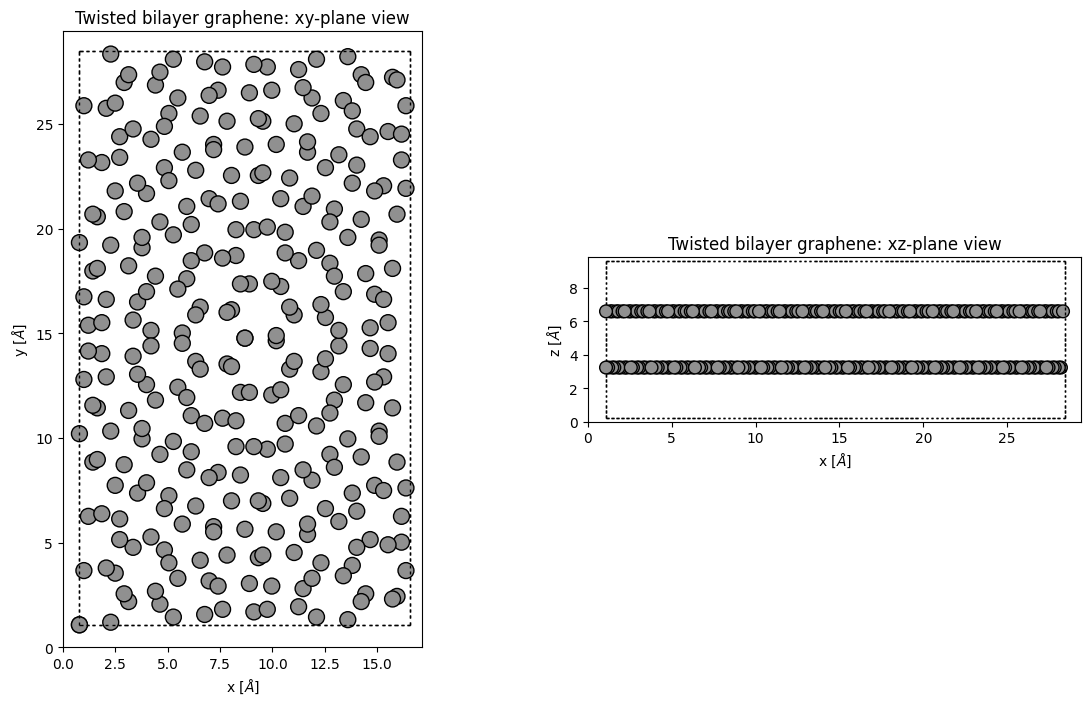

(array([ 0.00000000e+00, -0.00000000e+00, -6.48958368e-17]), array([1., 1., 1.]), array([-9.29965584e-17,  0.00000000e+00,  0.00000000e+00]))


In [6]:
import flatgraphene as fg

# see https://pypi.org/project/flatgraphene/:
rotation_angle = 9.43

p_found, q_found, theta_comp = fg.twist.find_p_q(rotation_angle)
graphene_twist = fg.twist.make_graphene(cell_type='hex',n_layer=2,
                             p=p_found,q=q_found,lat_con=0.0,a_nn=1.5,
                             sep=3.35,                  
                             h_vac=3)

orthogonal_cell, strain = orthogonalize_cell(graphene_twist, return_transform=True)

fig, axs = plt.subplots(1,2,figsize=(14,8))

plot_atoms(orthogonal_cell,axs[0],radii=0.5)
axs[0].set_xlabel(r"x [$\AA$]")
axs[0].set_ylabel(r"y [$\AA$]")
axs[0].set_title("Twisted bilayer graphene: xy-plane view")
plot_atoms(orthogonal_cell,axs[1],radii=0.5,rotation=('90x,90y,0z'))
axs[1].set_xlabel(r"x [$\AA$]")
axs[1].set_ylabel(r"z [$\AA$]")
axs[1].set_title("Twisted bilayer graphene: xz-plane view")

plt.show()
print(strain)

Simulate a 4D dataset.

In [7]:
material = 'Graphene'
energy = 300e3
defocus = -20
focal_spread = 50
angular_spread = 30
semiangle_cutoff = 100
doses = np.array([4.5])*1e7# also try 4.5,5.5,6.5
amplitudes = np.array([0,1])
Nphonons = 30
phonons = True
C_amplitude = 0.05
numPointsx = 60
numPointsy = 60
step_size = 0.15
savepath = "/users/stud/haffnerm/Ptychoshelves/fold_slice/ptycho/examples/Computational_noise_correction_in_4D_STEM/" # ENTER the desired destination here!!!

probe = Probe(energy=energy,defocus=defocus,focal_spread=focal_spread,angular_spread = angular_spread, semiangle_cutoff = semiangle_cutoff,device='gpu')
potentialMoS2bilayer = Potential(orthogonal_cell,
    sampling = 0.05,
    parametrization = 'lobato',
    device='gpu',
    storage='gpu')

fig, axs = plt.subplots(1,2,figsize=(15,5))
idx = 0
for amplitude in amplitudes:
    if (phonons):
        frozen_phonons = FrozenPhonons(orthogonal_cell,Nphonons,{'C' : amplitude * C_amplitude}, seed=1)
        potential_phonons = Potential(frozen_phonons, sampling=0.02)                
        probe.grid.match(potential_phonons)
      
    atoms_conf = next(iter(frozen_phonons))
    show_atoms(atoms_conf,ax=axs[idx])
    idx += 1                      
    detector = PixelatedDetector(max_angle = 'valid', resample='uniform')
    gridscan = GridScan(start=[0, 0], end=[numPointsx * step_size,numPointsy * step_size],gpts=(numPointsx,numPointsy), sampling=(0.02,0.02))

    print("scanning ... this may take up to one hour per dataset")
    if (phonons):
        measurement = probe.scan(gridscan,detector,potential_phonons)
    else:
        measurement = probe.scan(gridscan,detector,potentialMoS2bilayer)
    print("scan completed")

    measurement.show(cmap='inferno', power=.2);
    name = 'E_' + str(energy/1e3) + '_' + 'df_' + str(defocus) + 'dose_inf_' + 'amplitude_' + str(amplitude) + '.hdf5'
    measurement.write(savepath + name,mode='w',format='hdf5')
    for dose in doses:
        noisy_measurement = abtem.noise.poisson_noise(measurement,dose)
        name = material + '_E_' + str(energy/1e3) + '_' + 'df_' + str(defocus) + 'dose_' + str(dose/(1e7)) + 'e7_' + 'amplitude_' + str(amplitude) + '.hdf5'
        noisy_measurement.write(savepath + name,mode='w',format='hdf5')
        #noisy_measurement.show(cmap='inferno', power=.2);
        print("Data saved to" + savepath + name)
axs[0].set_title("Twisted bilayer graphene without phonons: xy-plane view")
axs[1].set_title("Twisted bilayer graphene with phonons: xy-plane view") 

scanning...


Potential:   0%|          | 0/19 [00:00<?, ?it/s]

TDS:   0%|          | 0/30 [00:00<?, ?it/s]

Scan:   0%|          | 0/3600 [00:00<?, ?it/s]

scan completed
Data saved to/users/stud/haffnerm/Ptychoshelves/fold_slice/ptycho/examples/Computational_noise_correction_in_4D_STEM/Graphene_E_300.0_df_-20dose_4.5e7_amplitude_0.hdf5
scanning...


Potential:   0%|          | 0/19 [00:00<?, ?it/s]

TDS:   0%|          | 0/30 [00:00<?, ?it/s]

Scan:   0%|          | 0/3600 [00:00<?, ?it/s]

scan completed


: 

: 

## Now create a dataset for MoS2.

(array([ 0.00000000e+00, -0.00000000e+00, -3.21498464e-16]), array([1., 1., 1.]), array([-3.21498464e-16,  0.00000000e+00,  0.00000000e+00]))


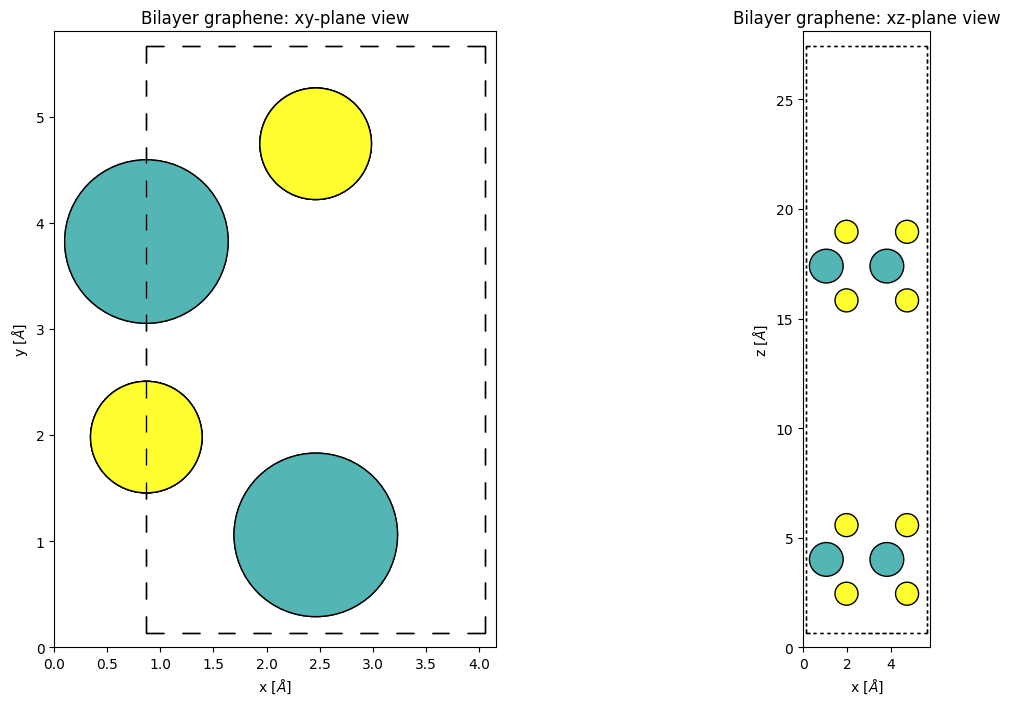

In [4]:
# See https://materialsproject.org/materials/mp-2815 for material data
a = 3.19
b = 3.19
c = 13.38
alpha = 90
beta = 90
gamma = 120

make_bilayer = True
make_rotated_bilayer = False
rotation_angle = 30

MoS2layer = Atoms('MoS2',[(1.596, 0.922, 10.034), (0, 1.843, 8.47), (0, 1.843, 11.598)],
                pbc=[1,1,0],
                cell=[a,b,c,alpha,beta,gamma])

if (make_bilayer):
    if (make_rotated_bilayer):
        MoS2layer2 = Atoms('MoS2',[(1.596, 0.922, 10.034), (0, 1.843, 8.47), (0, 1.843, 11.598)],
                    pbc=[1,1,0],
                    cell=[a,b,c,alpha,beta,gamma])
        MoS2layer2.rotate(rotation_angle,'z',rotate_cell=True,center='COP')
        MoS2bilayer = stack(MoS2layer,MoS2layer2,maxstrain=1)
    else:
        MoS2bilayer = surface(MoS2layer, indices=(0,0,1), layers=2, periodic=True)

    orthogonal_cell, strain = orthogonalize_cell(MoS2bilayer, return_transform=True)
    print(strain)
else:
    orthogonal_cell, strain = orthogonalize_cell(MoS2layer, return_transform=True)
    print(strain)

fig, axs = plt.subplots(1,2,figsize=(14,8))

plot_atoms(orthogonal_cell,axs[0],radii=0.5)
axs[0].set_xlabel(r"x [$\AA$]")
axs[0].set_ylabel(r"y [$\AA$]")
axs[0].set_title("Bilayer graphene: xy-plane view")
plot_atoms(orthogonal_cell,axs[1],radii=0.5,rotation=('90x,90y,0z'))
axs[1].set_xlabel(r"x [$\AA$]")
axs[1].set_ylabel(r"z [$\AA$]")
axs[1].set_title("Bilayer graphene: xz-plane view")

plt.show()  

In [ ]:
material = 'MoS2'
energy = 300e3
defocus = -20
semiangle_cutoff = 30
doses = np.array([5])*1e6 #also try 4.5,5.5,6.5
amplitudes = np.array([0,1])
Nphonons = 30
phonons = True
Mo_base_amplitude = 0.0692
S_base_amplitude = 0.0616
numPointsx = 60
numPointsy = 60
step_size = 0.2
savepath = "" # ENTER the desired destination here!!!

probe = Probe(energy=energy,defocus=defocus,semiangle_cutoff = semiangle_cutoff,device='gpu')
potentialMoS2layer = Potential(orthogonal_cell,
    sampling = 0.05,
    parametrization = 'lobato',
    device='gpu',
    storage='gpu')

fig, axs = plt.subplots(1,2,figsize=(15,5))
idx = 0
for amplitude in amplitudes:
    if (phonons):
        frozen_phonons = FrozenPhonons(orthogonal_cell,Nphonons,{'Mo' : amplitude * Mo_base_amplitude, 'S': amplitude * S_base_amplitude}, seed=1)
        potential_phonons = Potential(frozen_phonons, sampling=0.02)                
        probe.grid.match(potential_phonons)

    atoms_conf = next(iter(frozen_phonons))
    show_atoms(atoms_conf,ax=axs[idx])
    idx += 1
    detector = PixelatedDetector(max_angle = 120, resample='uniform')
    gridscan = GridScan(start=[0, 0], end=[numPointsx * step_size,numPointsy * step_size],gpts=(numPointsx,numPointsy), sampling=(0.02,0.02))

    print("scanning...")
    if (phonons):
        measurement = probe.scan(gridscan,detector,potential_phonons)
    else:
        measurement = probe.scan(gridscan,detector,potentialMoS2layer)
    print("scan completed")

    measurement.show(cmap='inferno', power=.2);
    for dose in doses:
        noisy_measurement = abtem.noise.poisson_noise(measurement,dose)
        name = material + '_E_' + str(energy/1e3) + '_' + 'df_' + str(defocus) + 'dose_' + str(dose/(1e7)) + 'e7_' + 'amplitude_' + str(amplitude) + '.hdf5'
        noisy_measurement.write(savepath + name,mode='w',format='hdf5')
        noisy_measurement.show(cmap='inferno', power=.2);
        print("Data saved to" + savepath + name)

axs[0].set_title("MoS2 bilayer without phonons: xy-plane view")
axs[1].set_title("MoS2 bilayer with phonons: xy-plane view")         